In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import os

In [2]:
# from tensorflow import keras

In [3]:
import tensorflow as tf

In [4]:
# tf.compat.v1.enable_eager_execution()

In [5]:
path = os.path.join("..", "dane", "clean", "test.csv")

df = pd.read_csv(path)
# df.head()

In [6]:
np.set_printoptions(suppress=False)
pd.set_option('float_format', '{:f}'.format)

In [7]:
tm = df['timestamp_ns']
tm = (tm/1e9).values
tm = tm-tm[0]

In [8]:
X = df['last'].values

In [9]:
X.shape, tm.shape

((22796,), (22796,))

In [10]:
N = 5600
N = 1500
X=X[:N]
tm = tm[:N]

# plt.plot(tm, X)

In [11]:
"INTERP"
tm_uniform = np.arange(tm[0], tm[-1], 1)
data_uniform = np.interp(tm_uniform, tm, X)
print(data_uniform.shape)
data_uniform = data_uniform.reshape(-1, 1)

(40655,)


In [12]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1)) #Also try QuantileTransformer
data_uniform_norm = scaler.fit_transform(data_uniform)

In [13]:
train_size = int(len(data_uniform) * 0.75)
test_size = len(data_uniform) - train_size
train, test = data_uniform_norm[:train_size,:], data_uniform_norm[train_size:,:]
train_orig, test_orig = data_uniform[:train_size,:], data_uniform[train_size:,:]

In [14]:
def to_sequences(array, seq_size=1, fwd_intervals=[1]):
    x = []
    y = []
    offset_arr = np.array(fwd_intervals)-1
    last_minus = max(fwd_intervals)    

    for i in range(len(array)-1-seq_size-last_minus):
        window = array[i:(i+seq_size), 0]
        x.append(window)

        sl_arr = offset_arr + i        
        sub_arr = array[i + seq_size + offset_arr, 0]
        y.append(sub_arr)
        
    return np.array(x), np.array(y)

def to_sequences_forward(array, seq_size=1, fwd_intervals=[1], transpose=False):
    x = []
    y = []
    offset_arr = np.array(fwd_intervals) - 1
    last_minus = max(fwd_intervals) - 1
    for i in range(len(array) - seq_size - last_minus):
        window = array[i:(i + seq_size), :]
        x.append(window)
        sub_arr = array[i + seq_size + offset_arr, :]
        y.append(sub_arr)
    return np.array(x), np.array(y)    

seq_size = 300  # Number of time steps to look back 
fwd_intervals = [1]
# fwd_intervals = np.arange(1,120,8)
fwd_size = len(fwd_intervals)


trainX, trainY = to_sequences_forward(train, seq_size, fwd_intervals)
testX, testY = to_sequences_forward(test, seq_size, fwd_intervals)

# trainX = trainX.reshape((trainX.shape[0],  fwd_size, seq_size))
# testX = testX.reshape((testX.shape[0],  fwd_size, seq_size))

trainY = trainY.reshape(-1, fwd_size)
testY = testY.reshape(-1, fwd_size)

trainX.shape, trainY.shape, testX.shape, testY.shape

((30191, 300, 1), (30191, 1), (9864, 300, 1), (9864, 1))

In [15]:
fwd_intervals

[1]

## MODEL

In [16]:
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import LSTM, Flatten
# from keras.layers import ConvLSTM2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, Flatten
from tensorflow.keras.layers import ConvLSTM2D

In [17]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_size, 1)))
model.add(LSTM(50))
model.add(Dense(50, activation='relu'))
# model.add(Dense(120))
model.add(Dense(fwd_size, activation='linear'))
model.compile(optimizer='adam', loss='mae')

model.fit(
    trainX, trainY, validation_data=(testX, testY),
    verbose=True, epochs=10, batch_size=100
)


Epoch 1/10
302/302 [==============================] - 13s 31ms/step - loss: 0.0099 - val_loss: 0.0354
Epoch 2/10
302/302 [==============================] - 8s 27ms/step - loss: 0.0031 - val_loss: 0.0352
Epoch 3/10
302/302 [==============================] - 8s 26ms/step - loss: 0.0031 - val_loss: 0.0308
Epoch 4/10
302/302 [==============================] - 8s 26ms/step - loss: 0.0034 - val_loss: 0.0326
Epoch 5/10
302/302 [==============================] - 8s 26ms/step - loss: 0.0026 - val_loss: 0.0366
Epoch 6/10
302/302 [==============================] - 8s 26ms/step - loss: 0.0023 - val_loss: 0.0339
Epoch 7/10
302/302 [==============================] - 8s 26ms/step - loss: 0.0023 - val_loss: 0.0275
Epoch 8/10
302/302 [==============================] - 8s 26ms/step - loss: 0.0024 - val_loss: 0.0311
Epoch 9/10
302/302 [==============================] - 8s 26ms/step - loss: 0.0023 - val_loss: 0.0363
Epoch 10/10
302/302 [==============================] - 8s 26ms/step - loss: 0.0024 - val_l

In [18]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
trainPredict.shape, testPredict.shape

309/309 [==============================] - 3s 8ms/step


((30191, 1), (9864, 1))

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [20]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

print()
trainScore = mean_absolute_error(trainY, trainPredict)
print('Train Score: %.2f ABE' % (trainScore))

testScore = mean_absolute_error(testY, testPredict)
print('Test Score: %.2f ABE' % (testScore))

Train Score: 0.00 RMSE
Test Score: 0.03 RMSE

Train Score: 0.00 ABE
Test Score: 0.02 ABE


In [21]:
trainPredict = scaler.inverse_transform(trainPredict.reshape(-1, fwd_size))
trainY = scaler.inverse_transform(trainY.reshape(-1, fwd_size))
testPredict = scaler.inverse_transform(testPredict.reshape(-1,fwd_size))
testY = scaler.inverse_transform(testY.reshape(-1, fwd_size))

trainPredict.shape, trainY.shape, testPredict.shape, testY.shape

((30191, 1), (30191, 1), (9864, 1), (9864, 1))

In [22]:
test.shape, test_orig.shape

((10164, 1), (10164, 1))

In [23]:
# test_orig = scaler.inverse_transform(test.reshape(-1, fwd_size))

In [24]:
print(testPredict.shape)

(9864, 1)


In [25]:
COLORS = [
    (0, 0.9, 0),
    (0, 0.7, 0.8),
    (0.9, 0, 0.6),
    (1, 0, 0),
    (0, 0, 0),    
]

In [26]:
from matplotlib.style import use
use('ggplot')

In [27]:
# x_orig.shape, test_orig.shape, test.shape, testY.shape

In [28]:
x_orig = np.arange(len(test_orig))
x_test = np.arange(len(testY))
test_orig.shape, test_orig[:, 0].shape

((10164, 1), (10164,))

In [29]:
fwd_intervals

[1]

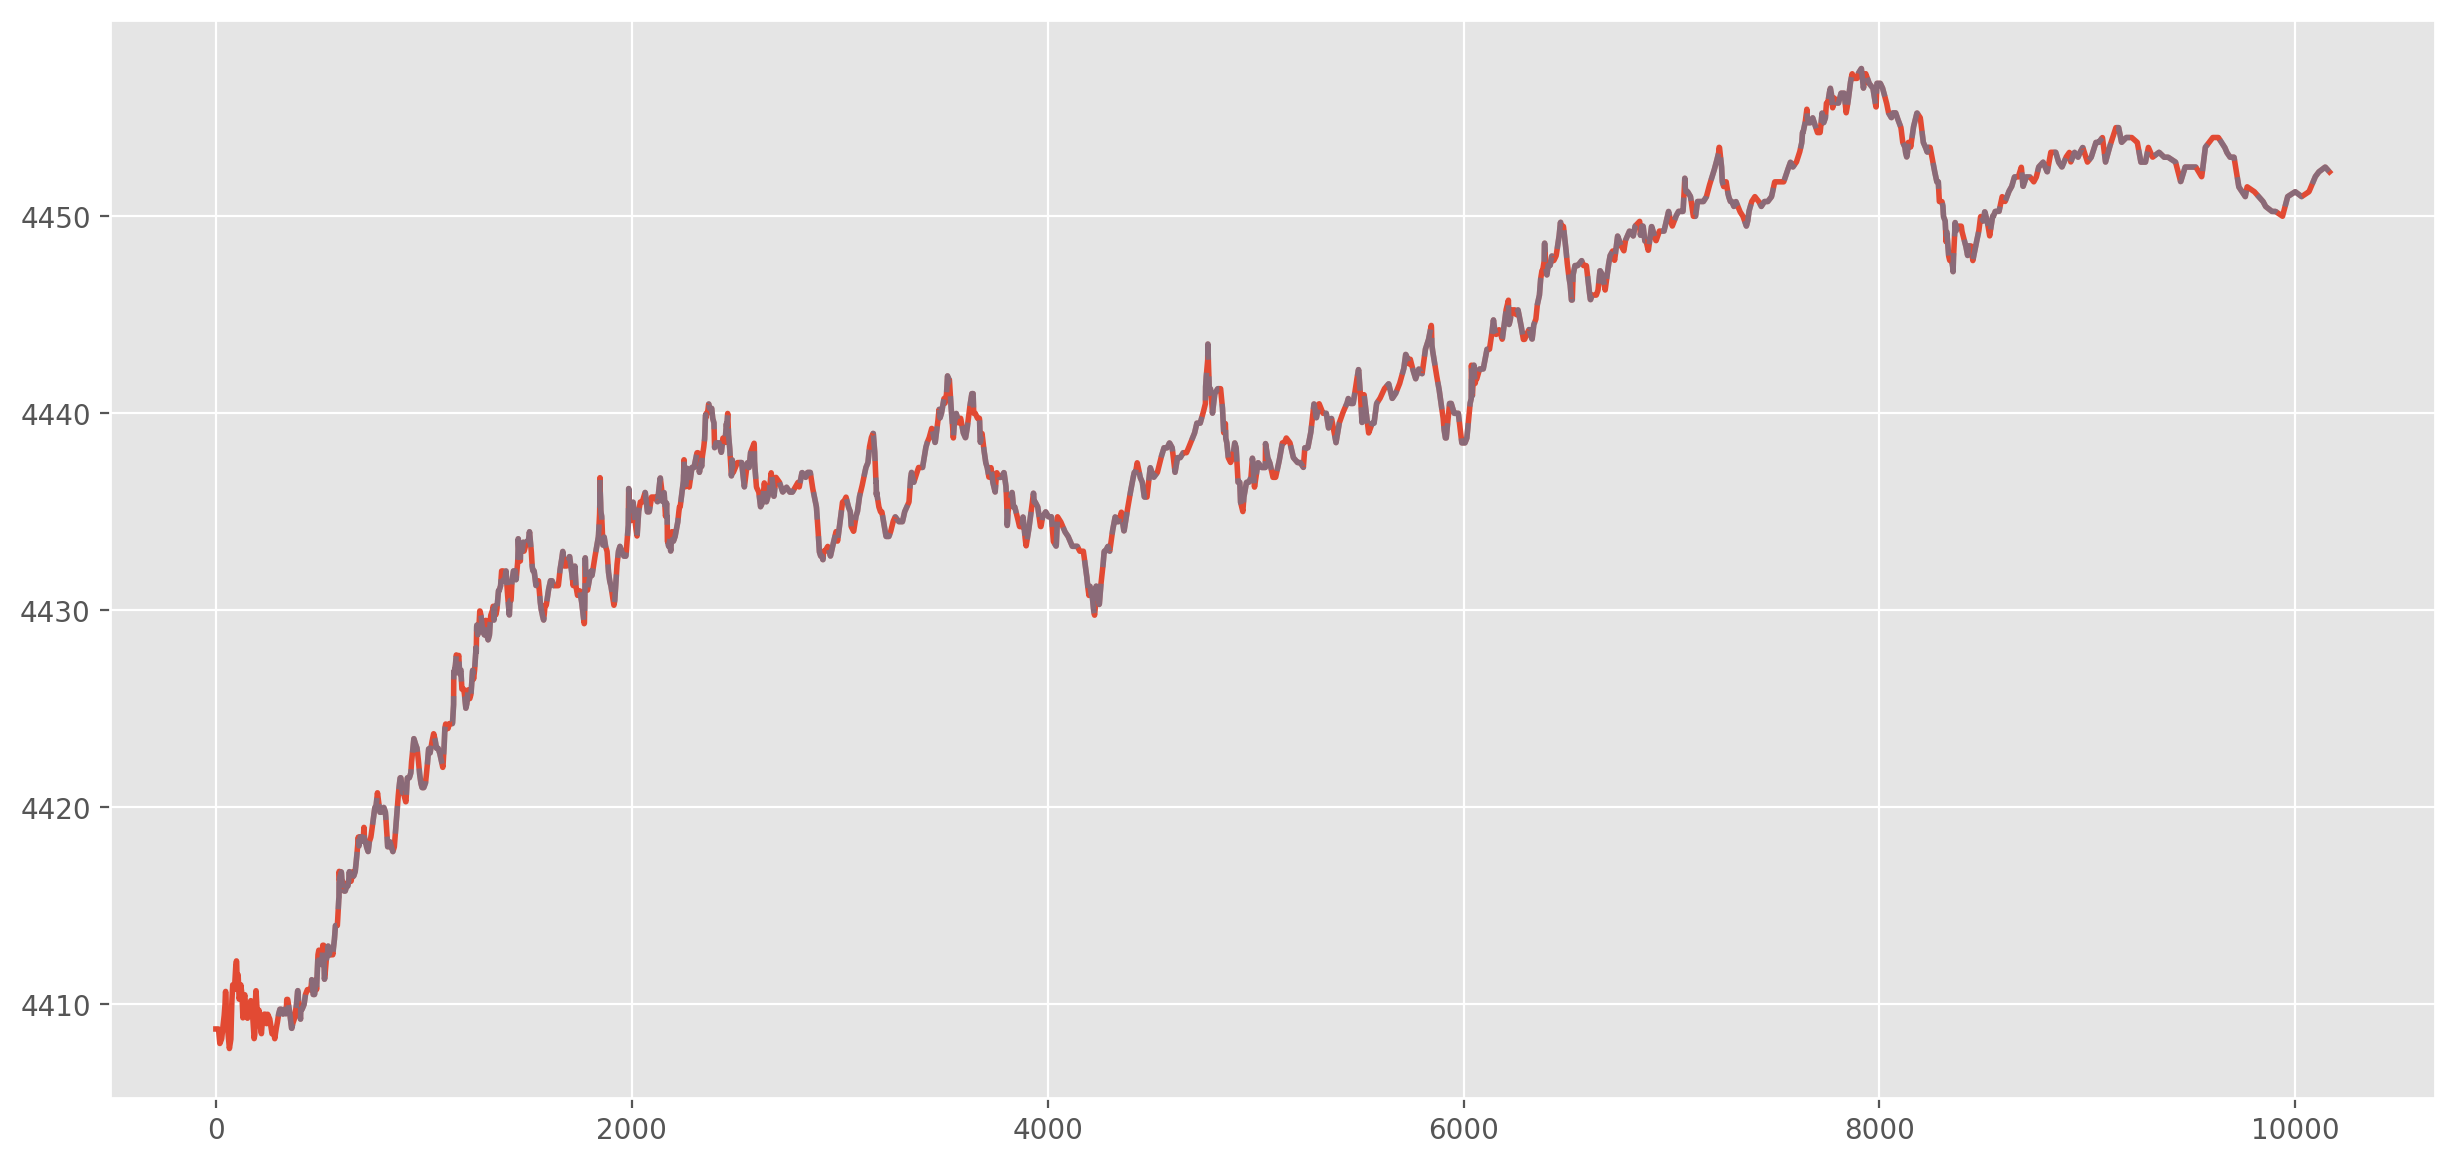

In [30]:
plt.figure(figsize=(15,7), dpi=200)
plt.plot(x_orig + 1, test_orig[:, 0], alpha=1, linewidth=2, label="OrigTest")
plt.plot(x_test + seq_size + fwd_intervals[0], testY[:,0], alpha=0.5, linewidth=2, label="TestY", dashes=[5,3])

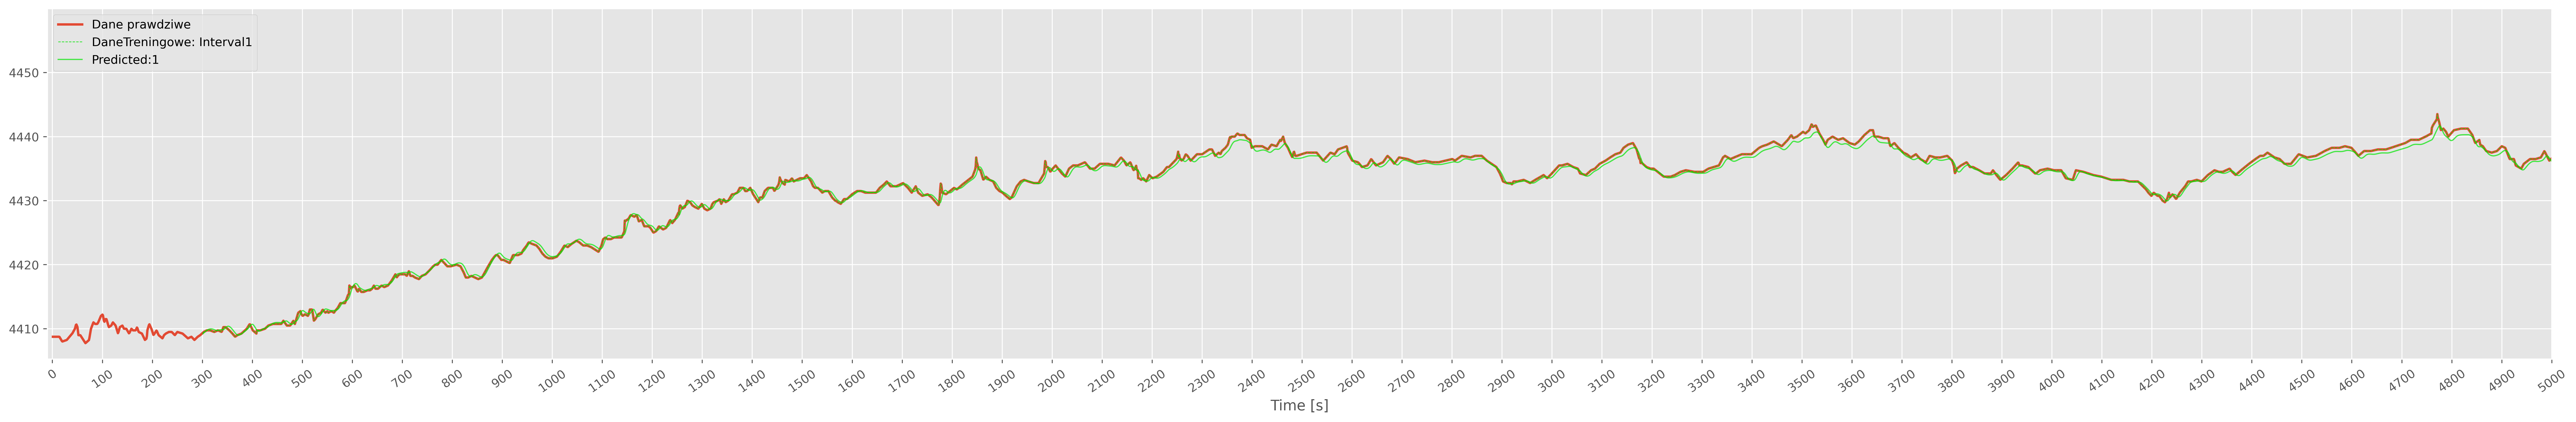

In [31]:
plt.figure(figsize=(30, 5), dpi=400)
plt.plot(x_orig+1, test_orig[:, 0], alpha=1, linewidth=2, label="Dane prawdziwe")
# plt.plot(x_test + seq_size + fwd_intervals[0], testY[:,0], alpha=0.9, linewidth=1, label="Dane Treningowe", dashes=[5,3])

for i, interv in enumerate(fwd_intervals):
    c = COLORS[i]
    plt.plot(x_test + seq_size + interv, testY[:, i], alpha=1, color=c, dashes=[4,2], linewidth=0.5, label=f"DaneTreningowe: Interval{fwd_intervals[i]}")
    plt.plot(x_test + seq_size + interv, testPredict[:, i], alpha=0.7, linewidth=1, color=c, label=f"Predicted:{interv}")


plt.legend(loc='upper left')
plt.xlabel('Time [s]')
plt.xlim([X[0], X[-1]])
plt.xlim([-10, 5000])
ax = plt.gca()
ax.locator_params(axis='x', nbins=100)
plt.xticks(rotation=35)
plt.tight_layout()
if (len(fwd_intervals) < 10):
    fwd_str = '_'.join(str(num) for num in fwd_intervals)
else:
    fwd_str = f"{fwd_intervals[0]}..{fwd_intervals[len(fwd_intervals)//2]}..{fwd_intervals[-1]}"
        
plt.savefig(f"predict_{fwd_str}.png")

In [32]:
testX.shape, testY.shape, testPredict.shape

((9864, 300, 1), (9864, 1), (9864, 1))

In [33]:
orig_test_x = scaler.inverse_transform(testX.reshape(-1, seq_size))

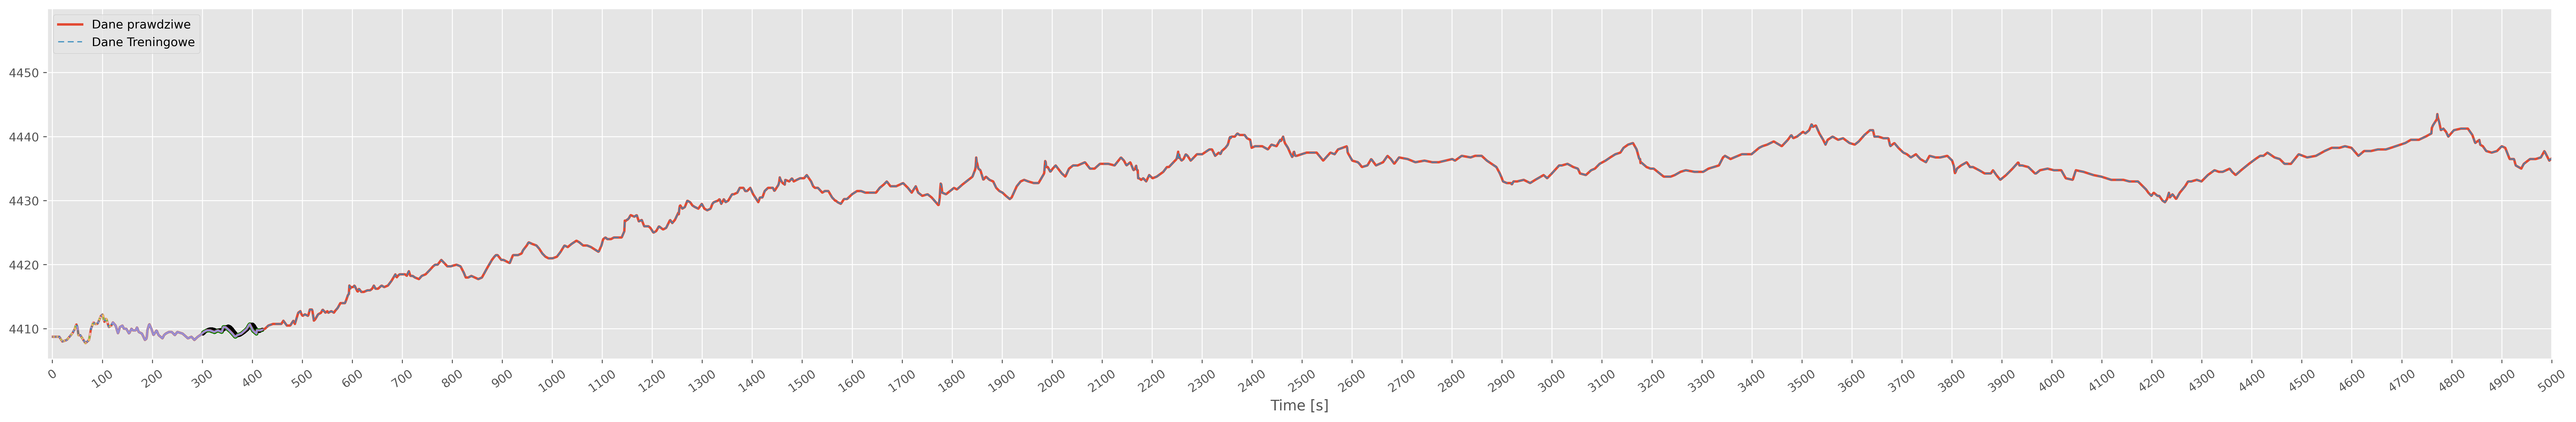

In [34]:
plt.figure(figsize=(30, 5), dpi=400)

plt.plot(x_orig+1, test_orig[:, 0], alpha=1, linewidth=2, label="Dane prawdziwe")

plt.plot(x_test + seq_size + fwd_intervals[0], testY[:,0], alpha=0.9, linewidth=1, label="Dane Treningowe", dashes=[5,3])

"Plot segment"

for i in range(120):
    test_xx = np.arange(len(orig_test_x[i,:]))+1+i
    plt.plot(test_xx, orig_test_x[i, :])
    plt.scatter(test_xx[-1]+ fwd_intervals[0], testY[i], c='green', s=8)
    plt.scatter(test_xx[-1]+ fwd_intervals[0], testPredict[i], c='black', s=6)

plt.legend(loc='upper left')
plt.xlabel('Time [s]')
plt.xlim([X[0], X[-1]])
plt.xlim([-10, 5000])
ax = plt.gca()
ax.locator_params(axis='x', nbins=100)
plt.xticks(rotation=35)
plt.tight_layout()
if (len(fwd_intervals) < 10):
    fwd_str = '_'.join(str(num) for num in fwd_intervals)
else:
    fwd_str = f"{fwd_intervals[0]}..{fwd_intervals[len(fwd_intervals)//2]}..{fwd_intervals[-1]}"
        
plt.savefig(f"predict_{fwd_str}_single.png")

## Re prediction

1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


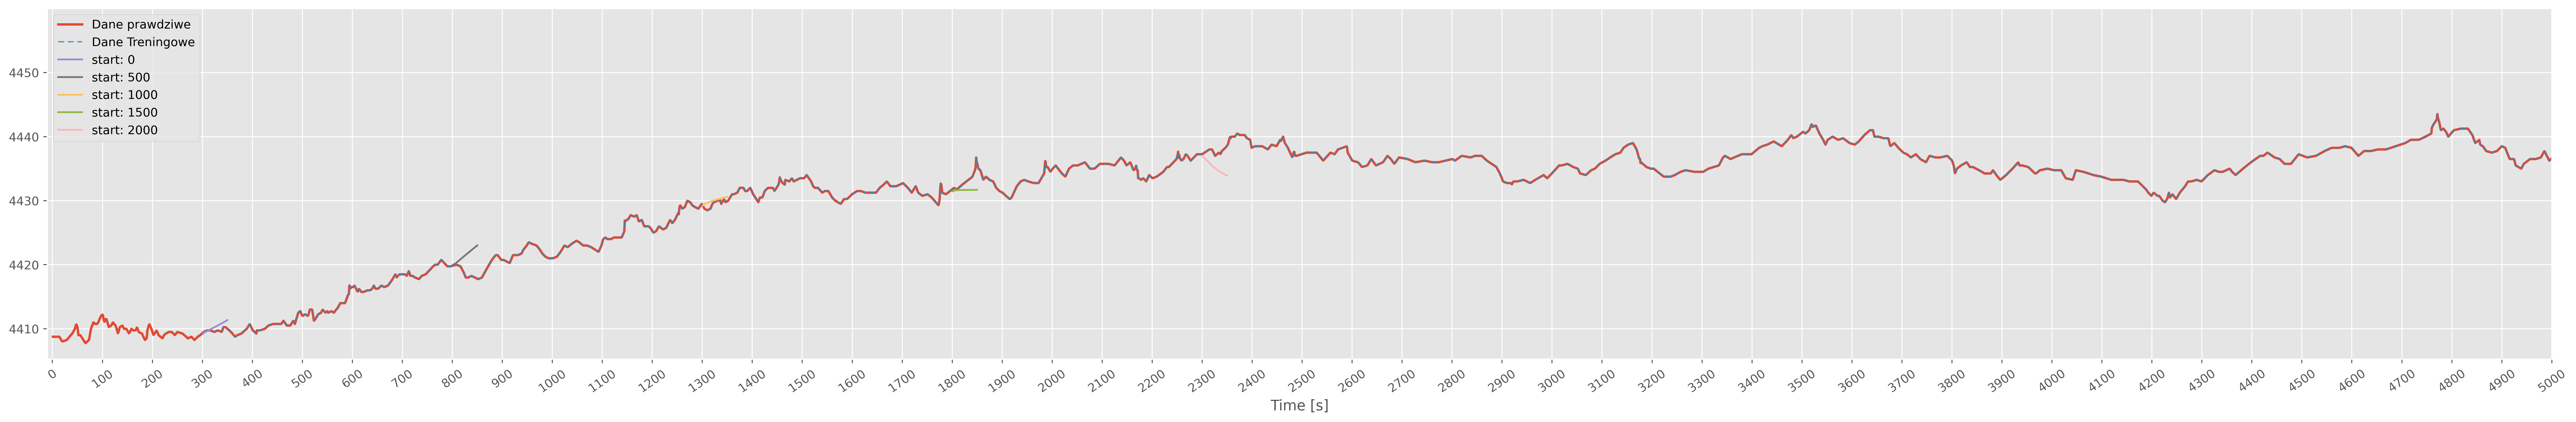

In [35]:
# y = model.predict(pred_x)


plt.figure(figsize=(30, 5), dpi=400)
plt.plot(x_orig+1, test_orig[:, 0], alpha=1, linewidth=2, label="Dane prawdziwe")
plt.plot(x_test + seq_size + fwd_intervals[0], testY[:,0], alpha=0.9, linewidth=1, label="Dane Treningowe", dashes=[5,3])


for start in [0, 500, 1000, 1500, 2000]:
    new_x = testX[start, :].reshape(1, -1, 1).copy()
    y_vals = []
    for i in range(50):    
    #     print("prediction:", new_x.ravel())
        y = model.predict(new_x)
        y_vals.append(y)
        y_temp = y.reshape(1, -1, 1)
        new_x = new_x[0, 1:, 0].reshape(1, -1, 1)

        new_x = np.concatenate([new_x, y_temp], axis=1)


    # y_temp = np.array(y_vals)
    y_temp = np.concatenate(y_vals, axis=0)
    y_vals_normal = scaler.inverse_transform(y_temp)
    yx = np.arange(len(y_vals))

    plt.plot(yx + start + seq_size + fwd_intervals[0], y_vals_normal, label=f"start: {start}")

plt.legend(loc='upper left')
plt.xlabel('Time [s]')
plt.xlim([X[0], X[-1]])
plt.xlim([-10, 5000])
ax = plt.gca()
ax.locator_params(axis='x', nbins=100)
plt.xticks(rotation=35)
plt.tight_layout()
if (len(fwd_intervals) < 10):
    fwd_str = '_'.join(str(num) for num in fwd_intervals)
else:
    fwd_str = f"{fwd_intervals[0]}..{fwd_intervals[len(fwd_intervals)//2]}..{fwd_intervals[-1]}"
        
plt.savefig(f"predict_{fwd_str}_repredict.png")